In [1]:
import pandas as pd
import numpy as np
dfCC = pd.read_csv('./procST4.csv')
returnMat = dfCC.to_numpy()
returnMat = returnMat[:,1:]
returnMat = returnMat.T
meanVecNP = returnMat.mean(axis=1)
covMatrix = np.cov(returnMat,bias=True)

In [2]:
from numpy import linalg as la

def nearestPD(A):
    B = (A + A.T) / 2
    _, s, V = la.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if isPD(A3):
        return A3
    spacing = np.spacing(la.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

def isPD(B):
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [3]:
# VaR
from gurobipy import Model,GRB
m = Model("VaR")
m.setParam('OutputFlag', 0)
epsl = .01
invNor = 1.645
meanVec = meanVecNP.tolist()
covMatPSD = nearestPD(covMatrix).tolist()
numAsset = len(meanVec)
x = m.addVars(numAsset,lb=0,ub=1, name="x") # x_j_k
t = m.addVar(lb=0,name="t")
m.setObjective(-sum(meanVec[i]*x[i] for i in range(numAsset))+invNor*t, GRB.MINIMIZE)
m.addConstr(sum(x[i] for i in range(numAsset)) <= 1)
m.addConstr(sum(x[i] for i in range(numAsset)) >= 1-epsl)
m.addQConstr(sum(covMatPSD[i][j]*x[i]*x[j] for i in range(numAsset) for j in range(numAsset)) <= t*t,"QC")
m.update()

Academic license - for non-commercial use only - expires 2021-08-17
Using license file c:\gurobi\gurobi.lic


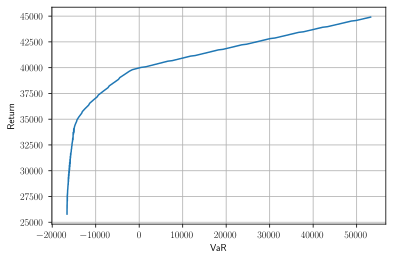

In [4]:
MinTarget = [i for i in range(25000,45000,100)]
risk_data = np.zeros(len(MinTarget))
ret_data = np.zeros(len(MinTarget))
count_divers = np.zeros(len(MinTarget))
dfExp = pd.DataFrame()
for j in range(len(MinTarget)):
#     print(MinTarget[j])
    m.addConstr(sum(x[i]*meanVec[i] for i in range(numAsset)) >= MinTarget[j],'BudgetConstr')
    try:
        m.optimize()
        Invest = m.getAttr('x',x)
        VaR = m.objVal
        m.remove(m.getConstrByName('BudgetConstr'))
        m.update()
        risk_data[j] = VaR
        investNP = np.array(Invest.values())
        ret_data[j] = meanVecNP.T.dot(np.round(investNP,2))
        count_divers[j] = np.sum(np.array(investNP) > .001, axis=0)
        dfExp[str(MinTarget[j]) +"_"+ str(np.round(VaR))] = np.round(investNP,3)
    except:
        break
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure()
plt.rc('text', usetex=True)
ax = fig.add_subplot(111)
plt.plot(risk_data[1:], ret_data[1:])
plt.xlabel('VaR')
plt.ylabel('Return')
plt.grid()
# plt.show()
plt.savefig("dfVaR_return_risk.pdf", bbox_inches = 'tight',pad_inches = 0)
# del m
# A negative VaR would imply the portfolio has a high probability of making a profit, 
# for example a one-day 5% VaR of negative $1 million implies the portfolio has a 95% 
# chance of making more than $1 million over the next day.

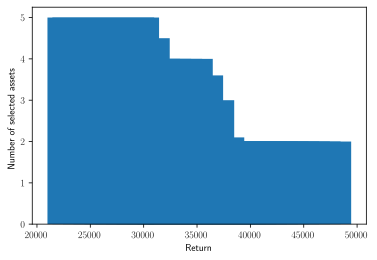

In [9]:
ret_data_bin = np.mean(np.stack( np.array_split(ret_data, 20), axis=0 ),axis=1)
count_divers_bin = np.mean(np.stack( np.array_split(count_divers, 20), axis=0 ),axis=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.bar(ret_data_bin , count_divers_bin,10000)
plt.xlabel('Return')
plt.ylabel('Number of selected assets')
plt.rc('text', usetex=True)
# plt.show()
plt.savefig("dfVaR_diversity.pdf", bbox_inches = 'tight',pad_inches = 0)

In [6]:
dfExp.head()

,25000_-16596.0,25100_-16596.0,25200_-16596.0,25300_-16596.0,25400_-16596.0,25500_-16596.0,25600_-16596.0,25700_-16596.0,25800_-16596.0,25900_-16596.0,...,44000_43279.0,44100_44381.0,44200_45484.0,44300_46587.0,44400_47690.0,44500_48795.0,44600_49900.0,44700_51005.0,44800_52111.0,44900_53218.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# dfExp.info(verbose=True)
dfExp.to_csv("dfVaR.csv")